# New bussines location indicator

## Coursera project capstone

This is the course captstone project for the coursera IBM machine learning specialization

### Structure:

This notebook is 6 parts:

  1. Introduction

  2. Source data and interest area organization.
  
      In this part, we will select the city and area of search as well as basic visualization, libraries imports and api/requests setup.
      
      
  3. Data Gattering
  
      Using the fourshared api, we will get the data we need.
      
      
  4. Methodology - Data organization and cleanup
  
      Here we will treat the received data to be able to use it for visualization and the final machine learning stage 
      
   
  5. Results
  
  5.1. Clustering
  
        We will find how many groups of coffee shop are there in the city by location and explore it also for the general venues.
      
      
      5-2. Ranking
  
     Two scores, ranging from 0 to 100 will be created, and all positions on the city map will receive this scores, one for amount of venues (high is better - more general venues) and one for amount of competition (high is worst - more coffee shops around). 
    
   6. Discussion
   
      
   7. Conclusion



## 1. About the project (Introduction)

Having a good location for your business is an important factor for it's prosperity. Although the hot spots in a city for a new venue are common knowledge, usually this places have a very high price given that it is correlated with higher demand. With some data mining and machine learning, some places can be discovered as good opportunities that have not yet received enough attention from people on the business.

This project uses python and some very helpful libraries for machine learning, visualization and data collection, to give some insight on where you should open your business in a city, based on how "hot" the area is and how many competitors are on the same business type, trying to maximize the fist and minimise the last. For the case study, the city chosen was Piracicaba, Brazil and the business type is a coffee shop, to the goal was to find a good place for a new coffee shop that has good location but not many competidors. 

To achieve this objective we will start by ranking the places in city by how 'hot' they are for business and them finding what is the optimal place for a new business that does not collide with other similar business by location but also is on a "hot spot" in the city. 

The data on the amount of venues by location will be collected using the foursquare api for a given city. The app/notebook will be created in a generic way so that people using it can change the city name. 
A map of the city based on the amount of venues will be created and also another one for the similar venues as the person is looking to create.

A score for a given location that will be created by adding value for number of venues using mahalanobis distance as a weight and the using the opposite (decreasing score) by having similar venues.
In the end, points will be clustered together to have useful locations as a suggestion for the new business to be opened.


### Let's start by importing the libraries we will need

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium, requests, os, time, itertools, pickle
import folium.plugins as plugins
from scipy.ndimage import imread
from bs4 import BeautifulSoup
from urllib.request import urlopen
from geopy.geocoders import Nominatim
from IPython.display import Image
from dotenv import load_dotenv
from math import sin, cos, sqrt, atan2, radians

## 2. Source data and interest area organization.

###  Defining the place of interest and search area

In [110]:
# this will be our center point in the city
lat_city_center, lng_city_center = -22.727482, -47.648811

# now, create a map with this lat and lng info
map_city = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
folium.CircleMarker(
        [lat_city_center, lng_city_center],
        radius=10,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  

In [111]:
# check if it is correct
map_city

In [112]:
# Defining the search grid size and location

In [113]:
number_x_points = 10
number_y_points = 10

lat_city_center, lng_city_center = -22.727482, -47.648811
# the farthest point of interest in the map
x_max, y_max =  -22.713566, -47.659758

# now we create a distance range in lat and lng distance measure
lat_delta = 2*np.abs(x_max - lat_city_center)
lng_delta = 2*np.abs(y_max - lng_city_center)

In [114]:
# create the matrix of points for use in the map and foursquare
lat_range = np.linspace(lat_city_center - lat_delta, lat_city_center + lat_delta, number_x_points)
lng_range = np.linspace(lng_city_center - lng_delta, lng_city_center + lng_delta, number_y_points)

In [115]:
lat_range

array([-22.755314  , -22.74912911, -22.74294422, -22.73675933,
       -22.73057444, -22.72438956, -22.71820467, -22.71201978,
       -22.70583489, -22.69965   ])

In [116]:
for lat in lat_range:
    for lng in lng_range:
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)
map_city

whe can see that we have covered most of the city with every point at around 200m from each other

##  3. Data Gattering

### Requesting the data from the location with foursquare api

In [117]:
# Client ID and cliet secret key shoud never be stored in the notebook or other script,
# so we read it from os enviroment variable. 
load_dotenv()

VERSION = '20180605' # Foursquare API version

CLIENT_ID = os.getenv('CLIENT_ID')          # your Foursquare ID
CLIENT_SECRET = os.getenv('CLIENT_SECRET')  # your Foursquare Secret

Creating some help functions to get and treat the data received

In [118]:
def get_info(lat, lng):
    '''
    This function call foursquare api with given lattitude and longtude and
    returns the api response as 
    '''
    url = f'https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={250}&limit={500}'
    results = requests.get(url).json()
    if results['meta']['code'] == 200:
        return results['response']
    return False

In [119]:
def count_venues(response):
    '''
    This function parse the response received from the get_info() function
    and treat it to filter only the number of venues in the area and retur it's number
    and a list of lat and lng data in a list o lists format
    '''
    try:
        points = []
        if response['venues']:    
            for i in range(len(response['venues'])):
                try:
                    lat = r['venues'][i]['location']['lat']
                    lng = r['venues'][i]['location']['lng']
                    points.append([lat, lng])
                except:
                    pass
            return len(response['venues']), points
    except:
        pass
    return 0, None

In [120]:
def count_similar(response, similar=['Café', 'Cafe', 'Coffe', 'Coffee Shops']):
    '''
    This function parse the response received from the get_info() function
    and count how many of then has similar text (eg: has the type we are looking for)
    and retur it's number
    '''
    total = 0 # we start with 0 matchs  
    try:
        points = []
        for venue in response['venues']:
            for item in venue['categories']:
                if  item['pluralName'] in similar or item['shortName'] in similar or item['name'] in similar:
                    total += 1
                    try:
                        lat = venue['location']['lat']
                        lng = venue['location']['lng']
                        points.append([lat, lng])
                    except:
                        pass
        return total, points
    except:
        return 0, None

In [121]:
# Let's just check the functions created
r = get_info(lat_city_center, lng_city_center)
print(f'number of coffe shops: {count_similar(r)[0]}')
print(f'number of venues in the center of the city: {count_venues(r)[0]}')
print(r['venues'][0]['location']['lat'])

number of coffe shops: 4
number of venues in the center of the city: 109
-22.727424355059128


In [122]:
print(r['venues'][1])

{'id': '4e6a0cbc7d8b143eb6eb28bd', 'name': 'Passarela Calçados', 'location': {'address': 'Gov. Pedro de Toledo', 'lat': -22.727786577073832, 'lng': -47.64798471403457, 'labeledLatLngs': [{'label': 'display', 'lat': -22.727786577073832, 'lng': -47.64798471403457}], 'distance': 91, 'cc': 'BR', 'city': 'Piracicaba', 'state': 'SP', 'country': 'Brasil', 'formattedAddress': ['Gov. Pedro de Toledo', 'Piracicaba, SP', 'Brasil']}, 'categories': [{'id': '4bf58dd8d48988d1f2941735', 'name': 'Sporting Goods Shop', 'pluralName': 'Sporting Goods Shops', 'shortName': 'Sporting Goods', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/sports_outdoors_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1580796432', 'hasPerk': False}


Now, we will search in all the opoints in the map

In [123]:
# the flag bellow is to avoid excess use of the api, loading the data if it already exists
new_scrap = False

filename = 'foursquare_data.pk'
if new_scrap:
    full_response, points_coffe, points_venue = [], [], []
    for lat in lat_range:
        line = []
        for lng in lng_range:
            r = get_info(lat, lng)
            similar, pt_temp_cofee = count_similar(r)
            venues, pt_temp_venue = count_venues(r)
            if pt_temp_venue:
                points_venue.extend(pt_temp_venue)
            if pt_temp_cofee:
                points_coffe.extend(pt_temp_cofee)
            line.append((similar, venues))
            time.sleep(1)
        full_response.append(line) 
    outfile = open(filename, 'wb')
    pickle.dump([full_response, points_coffe, points_venue], outfile)
    outfile.close()
else:
    infile = open(filename,'rb')
    full_response, points_coffe, points_venue = pickle.load(infile)
    infile.close()

In [124]:
# let's check what we got:

print(type(full_response),len(full_response), full_response[0])

<class 'list'> 10 [(0, 190), (0, 177), (0, 186), (0, 191), (0, 178), (0, 131), (0, 155), (0, 161), (0, 113), (0, 104)]


## 4. Data organization and cleanup

Let's just see the data format and visualize the results

In [125]:
# to plot a heatmap using folium.plugins.HeatMap, we will generate a data in the expected format
venue_matrix = np.zeros([number_x_points*number_y_points, 3])
coffe_matrix = np.zeros([number_x_points*number_y_points, 3])

# flatten the full response for easy of use
full_response_flat = list(itertools.chain(*full_response))

# now, populate the matrix with the info from "full_response" list from foursquare
i = 0
for lat in lat_range:
    for lng in lng_range:
        coffe_matrix[i] = (lat, lng, full_response_flat[i][0])
        venue_matrix[i] = (lat, lng, full_response_flat[i][1])
        i += 1

In [126]:
# and do some data threatment and formating

max_venue = venue_matrix[:,2].max()
min_venue = venue_matrix[:,2].min()
venue_matrix_normalized = (venue_matrix[:,2] - min_venue)/(max_venue - min_venue)

To plot using folium heatmap, we will create a list of points in the expected format:

In [127]:
points_venue = []
for venue in venue_matrix:
    for i in range(int((venue[2]/10))):
        points_venue.append([venue[0], venue[1]])

In [128]:
points_coffe = []
for venue in coffe_matrix:
    for i in range(int((venue[2]))):
        points_coffe.append([venue[0], venue[1]])

In [129]:
m_venues = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
m_venues.add_child(folium.plugins.HeatMap(points_venue, radius=20, min_opacity=0.2, blur=35, control_scale=False))
m_venues

In [130]:
m_cofee = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
m_cofee.add_child(folium.plugins.HeatMap(points_coffe, radius=70, min_opacity=0.2, blur=35, control_scale=False))
m_cofee

if both graphs where not able to render properly (the are some known bugs no mozilla for the heamap generation *), here are the plots as jped images

* https://github.com/python-visualization/folium/issues/812

## 5.1 Clustering

We will use k-means and the Elbow Method to see the amount of clusters for existing coffee shops and general venues

In [131]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, MinMaxScaler

In [132]:
def find_elbow_k(point):
    sse = []
    for k in range(1,10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(points_coffe)
        pred_clusters = kmeans.predict(point)
        centroids = kmeans.cluster_centers_
        curr_sse = 0
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points_coffe)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (point[i][0] - curr_center[0]) ** 2 + (point[i][1] - curr_center[1]) ** 2     
        sse.append(curr_sse)
    return sse

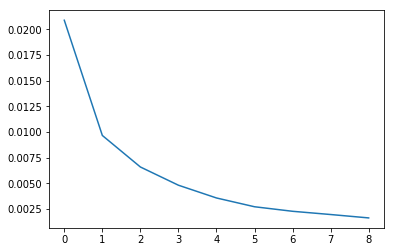

In [133]:
point = points_coffe
sse = find_elbow_k(point)
plt.plot(sse)

We can see that 4 or 5 blobs are a good start for places with coffe shops

In [134]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(points_coffe)
pred_clusters = kmeans.predict(point)
centroids = kmeans.cluster_centers_

In [135]:
m_cofee2 = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
m_cofee2.add_child(folium.plugins.HeatMap(points_coffe, radius=70, min_opacity=0.2, blur=35, control_scale=False))
for centroid in centroids:
    folium.CircleMarker(
        centroid,
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(m_cofee2)
m_cofee2

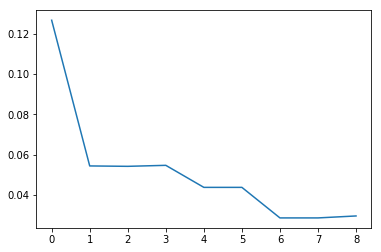

In [136]:
point = points_venue
sse = find_elbow_k(point)
plt.plot(sse)

For the general vennues, there is no direct group separations

In [137]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(point)
pred_clusters = kmeans.predict(point)
centroids = kmeans.cluster_centers_

In [138]:
m_cofee3 = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=13)
m_cofee3.add_child(folium.plugins.HeatMap(points_venue, radius=20, min_opacity=0.2, blur=35, control_scale=False))
for centroid in centroids:
    folium.CircleMarker(
        centroid,
        radius=10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(m_cofee3)
m_cofee3

## 5.2 Ranking

To wrap things up we will create and use an evaluation metrics for how good a given point is for a a possible coffee shop.
For this we will create an score for how crowded a place is and one for how far away from other customers (higher is also better). Both this scores will be normalized and them summed up.

For both of then, we will need a function for converting two points in lat lng format to meters:



In [139]:
def latlng_to_meters(lat1_deg, lon1_deg, lat2_deg, lon2_deg):
    '''
    Function that recevies two points int the lat lng (degre)
    and return the distance in meters
    '''
    R = 6373000.0 # Earth's radius
    lat1 = radians(lat1_deg)
    lon1 = radians(lon1_deg)
    lat2 = radians(lat2_deg)
    lon2 = radians(lon2_deg)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

Now, let's create an metric for how crowded a place is. we will summ all the near venues in a range (max_distance) and consider a maximum values if it is inside a minimum range. the convert function and graph are the following:

In [140]:
def how_crowded(pointA, pointB, max_range=500, min_range=50):
    distance = latlng_to_meters(pointA[0], pointA[1], pointB[0], pointB[1])
    if distance <= min_range:
        return 100
    elif distance >= max_range:
        return 0
    return 100 + (min_range*100)/(max_range-min_range) - distance*100/(max_range-min_range)

In [141]:
x = np.linspace(-22.755313999999995, -22.749129111111106, 300)
y = np.array([])

for xi in x:
    r = how_crowded((-22.755313999999995, -47.67070499999999), (xi, -47.67070499999999))
    y = np.append(y, r)

Text(0, 0.5, 'score')

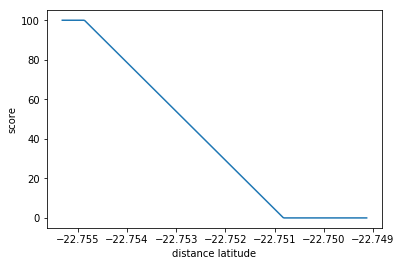

In [142]:
plt.plot(x, y)
plt.xlabel("distance latitude")
plt.ylabel("score")

The above graph shows how much score a venue will add to a location given its location. The consideration is that for places closer than 50 meters, they will score the highest (100) as we do not have precise location and can consider all this as really close ones. 

For the Highest distance, 500 meters was a arbitrary choice but this can be changed in the function parameter.

The same function can be used to evaluate coffe shops

### city points evaluation

For this, we will create a mesh of 500 by 500 and create a matrix score for general venues and coffee shops. After that, we will normalize the data and subtract both scores. The result will be an matrix whose highest scores will point to better locations for the new coffee shop to be located

In [143]:
grid_size = 50

In [144]:
lat_range = np.linspace(lat_city_center - lat_delta, lat_city_center + lat_delta, grid_size)
lng_range = np.linspace(lng_city_center - lng_delta, lng_city_center + lng_delta, grid_size)

In [145]:
crowd_venue_score = np.zeros((grid_size, grid_size))
crowd_coffe_score = np.zeros((grid_size, grid_size))

In [146]:
for i, lat in enumerate(lat_range):
    for j, lng in enumerate(lng_range):
        for point_coffe in points_coffe:
            crowd_coffe_score[i, j] += how_crowded((lat, lng), (point_coffe[0], point_coffe[1]))
        for point_venue in points_venue:
            crowd_venue_score[i, j] += how_crowded((lat, lng), (point_venue[0], point_venue[1]))

Now we normalize the two matrix

In [147]:
scaler1 = MinMaxScaler()
scaler1.fit(crowd_coffe_score)

scaler2 = MinMaxScaler()
scaler2.fit(crowd_venue_score)

crowd_coffe_score = scaler.transform(crowd_coffe_score)
crowd_venue_score = scaler.transform(crowd_venue_score)

In [148]:
print(coffe_score.max(), coffe_score.min())
print(venue_score.max(), venue_score.min())

0.5524682682208119 0.0
0.22205264875268138 0.02177928600621464


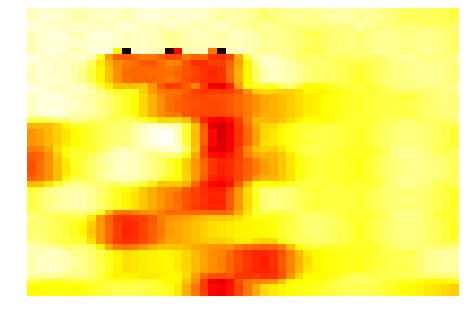

In [149]:
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(venue_score - coffe_score, aspect='auto', cmap='hot')
fig.savefig('heat.png')

### Now we finaly show the map

The red parts are the optimal places for a new coffee shop

In [150]:
lat_range = np.linspace(lat_city_center - lat_delta, lat_city_center + lat_delta, grid_size)
lng_range = np.linspace(lng_city_center - lng_delta, lng_city_center + lng_delta, grid_size)
# boundary of the image on the map
min_lon = lng_city_center - lng_delta
max_lon = lng_city_center + lng_delta
min_lat = lat_city_center - lat_delta
max_lat = lat_city_center + lat_delta

# create the map
final_map = folium.Map(location=[lat_city_center, lng_city_center],
                  zoom_start = 14)

# read in png file to numpy array
data = imread('heat.png')

# Overlay the image
final_map.add_children(raster_layers.ImageOverlay(data, opacity=0.8, \
        bounds =[[min_lat, min_lon], [max_lat, max_lon]]))
final_map

C:\Users\Gustavo\Anaconda2\envs\tf3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
C:\Users\Gustavo\Anaconda2\envs\tf3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


## 7. Conclusion

with all the tools available in this libraries, was possible to develop and visualize a fast solution for a common type of problem. The metrics used for the score evaluation are overly simplified but can be better customizes with the addition of more data from api's os specialists but overall the results are promising and are inline with expected for persons that know the area studied